In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%env CHRONOSTRAIN_INI=/home/youn/work/chronostrain/examples/umb/files/chronostrain.ini
%env CHRONOSTRAIN_DB_JSON=/mnt/e/ecoli_db/chronostrain_files/ecoli.json
%env CHRONOSTRAIN_DB_DIR=/mnt/e/ecoli_db/chronostrain_files
%env CHRONOSTRAIN_CACHE_DIR=./cache
%env CHRONOSTRAIN_LOG_INI=./logging.ini
%env JAX_PLATFORM_NAME=cpu


from typing import *
from pathlib import Path
import numpy as np
import jax
import pandas as pd

from chronostrain.config import cfg
from chronostrain.database import *

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sb

from Bio import Phylo
from helpers import *

env: CHRONOSTRAIN_INI=/home/youn/work/chronostrain/examples/umb/files/chronostrain.ini
env: CHRONOSTRAIN_DB_JSON=/mnt/e/ecoli_db/chronostrain_files/ecoli.json
env: CHRONOSTRAIN_DB_DIR=/mnt/e/ecoli_db/chronostrain_files
env: CHRONOSTRAIN_CACHE_DIR=./cache
env: CHRONOSTRAIN_LOG_INI=./logging.ini
env: JAX_PLATFORM_NAME=cpu


In [3]:
# Ensure that basic bash commands work.

try:
    VARS_SET
except NameError:
    VARS_SET = True
    _cwd = %pwd
    _parent_cwd = Path(_cwd).parent
    _start_path = %env PATH
    %env PATH=$_start_path:/usr/bin


# zcat is needed by bowtie2
!zcat --version  # if this doesn't work, then install "gzip" (e.g. conda install -c conda-forge gzip)

env: PATH=/home/youn/mambaforge/envs/chronostrain/bin:/usr/bin
zcat (gzip) 1.12
Copyright (C) 2007, 2011-2018 Free Software Foundation, Inc.
This is free software.  You may redistribute copies of it under the terms of
the GNU General Public License <https://www.gnu.org/licenses/gpl.html>.
There is NO WARRANTY, to the extent permitted by law.

Written by Paul Eggert.


# Phylogroup-based labelling/coloring

In [4]:
def annotate_phylogroups(db: StrainDatabase, phylogroup_path: Path):
    """To each strain, add a phylogroup annotation."""
    for strain in db.all_strains():
        strain.phylogroup = '?'
    
    with open(phylogroup_path, 'r') as f:
        for line in f:
            tokens = line.strip().split('\t')
            accession = Path(tokens[0]).with_suffix('').with_suffix('').name
            phylogroup = tokens[4]
            try:
                db.get_strain(accession).phylogroup = phylogroup
            except QueryNotFoundError:
                pass
    

def create_palette(db: StrainDatabase):
    palette_tab20 = sb.color_palette("tab20", 20)
    phylogroup_colors = {
        'A': palette_tab20[4],
        'B1': palette_tab20[1],
        'B2': palette_tab20[6],
        'C': palette_tab20[0],
        'D': 'gold',
        'E': palette_tab20[8],
        'F': palette_tab20[7],
        'G': palette_tab20[5],
        'fergusonii': palette_tab20[2],
        'albertii': palette_tab20[3],
        'E or cladeI': palette_tab20[9],
        'cladeI': palette_tab20[10],
        'Unknown': palette_tab20[11],
        'cladeV': palette_tab20[12],
        '?': np.array([0.0, 0.0, 0.0, 1.0])
    }
    strain_colors = {
        s.id: phylogroup_colors[s.phylogroup]
        for s in db.all_strains()
    }
    return phylogroup_colors, strain_colors

In [5]:
db = cfg.database_cfg.get_database()
annotate_phylogroups(db, phylogroup_path=Path("/mnt/e/ecoli_db/phylogeny/ClermonTyping/umb_phylogroups_complete.txt"))
clades = [
    "A", "B1", "B2", "C", "D", "E", "F", "G", 
    "fergusonii", "albertii", "E or cladeI", "cladeI", "Unknown", "cladeV",
    "N/A"
]
phylo_colors, strain_colors = create_palette(db)

abx_acronym = {'nitrofuran': 'N', 'fluoroquinolone': 'F', 'beta_lactam': 'B', 'sulfonamide': 'S', 'macrolide': 'M', 'tetracycline': 'T'}
abx_colors = {'nitrofuran': 'red', 'fluoroquinolone': 'magenta', 'beta_lactam': 'green', 'sulfonamide': 'blue', 'macrolide': 'cyan', 'tetracycline': 'orange'}
abx_labels = {'nitrofuran': 'Nitrofurantoin', 'fluoroquinolone': 'Fluoroquinolone', 'beta_lactam': 'Beta Lactam', 'sulfonamide': 'Sulfonamide', 'macrolide': 'Macrolide', 'tetracycline': 'Tetracycline'}

# StrainGST stuff

In [25]:
# ======================================= Parsing
umb_entries = parse_umb_entries(
    straingst_output_basedir=Path("/mnt/e/strainge/straingst_umb"),
    entries_csv_path=Path("/home/youn/work/chronostrain/examples/umb/files/umb_samples.csv")
)
umb_dates_df = retrieve_patient_dates(umb_entries)
straingst_df = straingst_dataframe(
    umb_entries,
    Path("/mnt/e/chronostrain/phylogeny/ClermonTyping/umb_phylogroups_complete.txt")
)

In [26]:
straingst_df

,Patient,SampleName,Date,StrainName,Species,StrainId,Phylogroup,RelAbund
0,UMB01,UMB01_00,2015-10-26,FDAARGOS_1254,coli,NZ_CP069453.1,B2,0.00080
1,UMB01,UMB01_00,2015-10-26,CFS3313,coli,NZ_CP026939.2,B1,0.00071
2,UMB01,UMB01_00urt,2015-10-27,PK8566,coli,NZ_CP080172.1,B1,0.33710
3,UMB01,UMB01_01,2015-11-11,CFS3313,coli,NZ_CP026939.2,B1,0.00179
4,UMB01,UMB01_03,2016-01-06,FDAARGOS_1254,coli,NZ_CP069453.1,B2,0.01637
...,...,...,...,...,...,...,...,...
358,UMB08,UMB_8_08_2,2016-06-07,WP8-S17-ESBL-12,coli,NZ_AP022222.1,D,0.06697
359,UMB08,UMB_8_12,2016-10-06,A13,coli,NZ_CP028761.1,B2,0.37312
360,UMB08,UMB_8_12,2016-10-06,RIVM_C028620,coli,NZ_CP068815.1,B2,0.40659
361,UMB08,UMB_8_12_2,2016-10-06,A13,coli,NZ_CP028761.1,B2,0.40723


# Function for plotting UMB

In [8]:
base_dir = Path("/data/cctm/youn/umb")
stool_bf_threshold = 100000.0
urine_bf_threshold = 100000.0
prior_p = 0.001

# What is the probability threshold?
_x = stool_bf_threshold * (prior_p / (1 - prior_p))
p_threshold = _x / (_x + 1)
print("stool BF threshold = {} // p threhsold = {}".format(stool_bf_threshold, p_threshold))

_x = urine_bf_threshold * (prior_p / (1 - prior_p))
p_threshold = _x / (_x + 1)
print("urine BF threshold = {} // p threhsold = {}".format(urine_bf_threshold, p_threshold))


# ====== Load results
res_cache = {}

def load_result(umb_id):
    if umb_id in res_cache:
        return
    res = {
        'stool': ChronostrainResult(
            umb_id,
            db, 
            GaussianStrainCorrelatedWithGlobalZerosPosterior,
            base_dir / 'stool' / umb_id / 'chronostrain', 
            base_dir / 'stool' / umb_id / 'filtered' / 'filtered_reads.csv',
            target_bayes_factor=stool_bf_threshold
        ),
        'urine': ChronostrainResult(
            umb_id,
            db, 
            GaussianStrainCorrelatedWithGlobalZerosPosterior,
            base_dir / 'urine' / umb_id / 'chronostrain', 
            base_dir / 'urine' / umb_id / 'filtered' / 'filtered_reads.csv',
            target_bayes_factor=urine_bf_threshold
        ),
        'culture': None
    }
    res_cache[umb_id] = res

stool BF threshold = 100000.0 // p threhsold = 0.9901088129585441
urine BF threshold = 100000.0 // p threhsold = 0.9901088129585441


In [9]:
def load_abx_df(umb_id) -> pd.DataFrame:
    abx_df = pd.read_csv(Path().resolve().parent / 'files' / 'abx_table.tsv', sep="\t").astype(
        dtype={
            'experiment_day_ended': 'int64',
            'date_ended': 'datetime64[ns]'
        }
    )
    umb_df = pd.read_csv(Path(Path().resolve().parent / 'files' / 'umb_samples.csv'))
    umb_dates = umb_df.groupby('ID').head(1)[['ID', 'date', 'days']].astype({'date': 'datetime64[ns]'})
    umb_dates.columns = ['ID', 'ref_date', 'ref_days']

    abx_df = abx_df.merge(umb_dates, left_on='patient_id', right_on='ID')
    abx_df['experiment_day_ended'] = (abx_df['date_ended'] - abx_df['ref_date']).dt.days + abx_df['ref_days']
    abx_df = abx_df[['patient_id', 'raw_abx', 'clean_abx', 'abx_class', 'date', 'days_before', 'weeks_before', 'date_ended', 'experiment_day_ended']]
    return abx_df.loc[abx_df['patient_id'] == umb_id]


def load_uti_df(umb_id) -> pd.DataFrame:
    uti_df = pd.read_csv(Path().resolve().parent / 'files' / 'utis.csv').astype({'UTIDate': 'datetime64[ns]'})
    uti_df = uti_df.loc[uti_df['Patient'] == umb_id]
    
    umb_df = pd.read_csv(Path(Path().resolve().parent / 'files' / 'umb_samples.csv'))
    umb_dates = umb_df.groupby('ID').head(1)[['ID', 'date', 'days']].astype({'date': 'datetime64[ns]'})
    umb_dates.columns = ['ID', 'ref_date', 'ref_days']
    
    uti_df = uti_df.merge(umb_dates, left_on='Patient', right_on='ID')
    uti_df['UTIDay'] = (uti_df['UTIDate'] - uti_df['ref_date']).dt.days + uti_df['ref_days']
    uti_df = uti_df[['Patient', 'UTIDate', 'UTIDay']]
    
    return uti_df


def load_sample_df(umb_id) -> pd.DataFrame:
    df = pd.read_csv(Path().resolve().parent / 'files' / "umb_samples.csv", sep=',').astype({
        'date': 'datetime64[ns]'
    })
    df['T'] = df['days']
    return df.loc[df['ID'] == umb_id, ['Run', 'ID', 'SampleName', 'date', 'Group', 'type', 'T']]

In [103]:
from chronostrain.inference import *


def plot_umb(umb_id: str, base_dir: Path, seed: int, result_cache: Dict[str, Dict[str, ChronostrainResult]], width: float, include_straingst: bool):
    cfg.engine_cfg.prng_key = jax.random.PRNGKey(seed)  # for reproducibility
    res = result_cache[umb_id]
    stool_result = res['stool']
    urine_result = res['urine']
    culture_result = res['culture']
        
        
    plotter = ChronostrainRenderer(
        abund_lb=0.1, 
        target_taxon=Taxon("Escherichia", "coli"), 
        strain_palette=strain_colors,
        stool_result=stool_result,
        urine_result=urine_result,
        abx_df=load_abx_df(umb_id),
        abx_palette=abx_colors,
        abx_label=abx_acronym,
        uti_df=load_uti_df(umb_id),
        sample_df=load_sample_df(umb_id)
    )
    
    sb.set_style("whitegrid")

    if not include_straingst:
        scatterplot_n_taxa = len(pd.unique(plotter.get_merged_df()['StrainId']))
        scatterplot_ht_scale = scatterplot_n_taxa / 8
        fig = plt.figure(constrained_layout=True, figsize=(width, 2.0 * (1.2 + scatterplot_ht_scale) + 4.0))
        gs = gridspec.GridSpec(ncols=2, nrows=3, figure=fig, height_ratios=[0.3, scatterplot_ht_scale, 1], width_ratios=[1, 2])
    else:
        scatterplot_n_taxa_chronostrain = len(pd.unique(plotter.get_merged_df()['StrainId']))
        scatterplot_ht_scale_chronostrain = scatterplot_n_taxa_chronostrain / 8

        straingst_res_umb = straingst_df.loc[straingst_df['Patient'] == umb_id]
        scatterplot_n_taxa_straingst = len(pd.unique(straingst_res_umb['StrainId']))
        scatterplot_ht_scale_straingst = scatterplot_n_taxa_straingst / 8
        
        fig = plt.figure(constrained_layout=True, figsize=(width, 2.0 * (1.2 + scatterplot_ht_scale_chronostrain + scatterplot_ht_scale_straingst) + 3.0))
        gs = gridspec.GridSpec(ncols=2, nrows=5, figure=fig, height_ratios=[0.2, scatterplot_ht_scale_chronostrain, 1, scatterplot_ht_scale_straingst, 1], width_ratios=[1, 2])
        

    # ====================== legend axis
    legend_ax = fig.add_subplot(gs[0, :])
    
    # ====================== Phylogroup legend
    legends = []
    handles, labels = zip(*[
        (legend_ax.scatter([], [], facecolors=phylo_colors[p]), p) 
        for p in ['A', 'B1', 'B2', 'C', 'D', 'E', 'F', 'G', 'E or cladeI', 'cladeI', 'cladeV', 'Unknown']
    ])
    phylogroup_legend = plt.legend(handles, labels, title="Phylogroup", bbox_to_anchor=(0.15, 0.5), loc="center left", ncol=6)
    legends.append(phylogroup_legend)

    # ====================== ABX Legend
    def create_text_legend_proxy(label, color):
        """
        Hack to use Letter-based markers for legend creation
        """
        t = matplotlib.textpath.TextPath(xy=(0, -.2), s=label, size=0.5)
        line = matplotlib.lines.Line2D(
            [0], [-1], linestyle='none',
            marker=t, markeredgecolor=color, markerfacecolor=color, markersize=20.0, markeredgewidth=0.1,
        )
        return line
    
    _abx = set(pd.unique(plotter.abx_df['abx_class']))
    abx_lbls = [
        (
            create_text_legend_proxy(abx_acronym[abx_name], abx_colors[abx_name]),
            abx_label
        )
        for abx_name, abx_label in abx_labels.items()
        if abx_name in _abx
    ]
    if len(abx_lbls) > 0:
        handles, labels = zip(*abx_lbls)
        abx_legend = plt.legend(handles, labels, title="Antibiotics", bbox_to_anchor=(0.75, 0.5), loc="center left", ncol=3)
        legends.append(abx_legend)

    # ======================= Render legends
    legend_ax.axis('off')
    for legend in legends:
        legend_ax.add_artist(legend)
    
    # ===================== Tree
    marker_tree = Phylo.read(str("/mnt/e/ecoli_db/phylogeny/tree/tree.nwk"), "newick")
    marker_tree.ladderize()
    tree_ax = fig.add_subplot(gs[1, 0])
    x_posns, y_posns = plotter.plot_tree(
        ax=tree_ax,
        tree=marker_tree
    )
    tree_ax.set_title("Marker distance")

    
    timeseries_axes = []
    # ===================== Clade marker scatterplots
    marker_sz = 0.5 # scatterplot marker size
    scatter_ax = fig.add_subplot(gs[1, 1])
    timeseries_axes.append(scatter_ax)
    # pre-compute ordering.
    y_ordering = [(clade.name, y_pos) for clade, y_pos in y_posns.items() if clade.is_terminal()]
    y_ordering = sorted(y_ordering, key=lambda p: p[1])
    y_ordering = {
        acc: len(y_ordering) - y_idx
        for y_idx, (acc, y_pos) in enumerate(y_ordering)
    }
    plotter.plot_clade_presence(
        scatter_ax, strain_y=y_ordering
    )
    
    # ===================== Relative Abundance lineplot
    abund_ax = fig.add_subplot(gs[2, 1])
    timeseries_axes.append(abund_ax)
    ymin, ymax = plotter.plot_overall_relabund(abund_ax, mode='stool')
    abund_ax.set_ylim(bottom=max(ymin, 1e-7), top=min(ymax*10, 1.0))
    scatter_ax.sharex(abund_ax)

    if include_straingst:
        tree_ax2 = fig.add_subplot(gs[3, 0])
        mash_tree = Phylo.read(str("/mnt/e/ecoli_db/phylogeny/tree/mash_tree.nwk"), "newick")
        mash_tree.ladderize()
        _, straingst_y_posns = plot_tree(straingst_res_umb, phylo_colors, tree_ax2, mash_tree)
        tree_ax2.set_title("Whole-genome distance")
        straingst_y_ordering = [(clade.name, y_pos) for clade, y_pos in straingst_y_posns.items() if clade.is_terminal()]
        straingst_y_ordering = sorted(straingst_y_ordering, key=lambda p: p[1])
        straingst_y_ordering = {
            acc: len(straingst_y_ordering) - y_idx
            for y_idx, (acc, y_pos) in enumerate(straingst_y_ordering)
        }

        clade_ax2 = fig.add_subplot(gs[3, 1])
        plot_clade_presence(
            straingst_res_umb, 
            umb_dates_df.loc[umb_dates_df['Patient'] == umb_id],
            phylo_colors,
            clade_ax2,
            strain_y=straingst_y_ordering,
            show_ylabels=True
        )
        clade_ax2.sharex(abund_ax)
        timeseries_axes.append(clade_ax2)
        
        abund_ax2 = fig.add_subplot(gs[4, 1])
        plot_straingst_abundances(
            straingst_res_umb, 
            umb_dates_df.loc[umb_dates_df['Patient'] == umb_id],
            phylo_colors,  abund_ax2, mode='stool', yscale='log'
        )
        abund_ax2.sharey(abund_ax)
        abund_ax2.sharex(abund_ax)
        timeseries_axes.append(abund_ax2)

    # ================== ABX
    for ax in timeseries_axes:
        plotter.plot_abx(ax, draw_labels=True)

    # ================== Infections
    for ax in timeseries_axes:
        plotter.plot_infections(ax)

    # ================== Xtick transform integers to dates.
    plotter.set_xtick_dates(timeseries_axes[-1], show_t=False)
    for ax in timeseries_axes[:-1]:
        ax.tick_params(labelbottom=False)

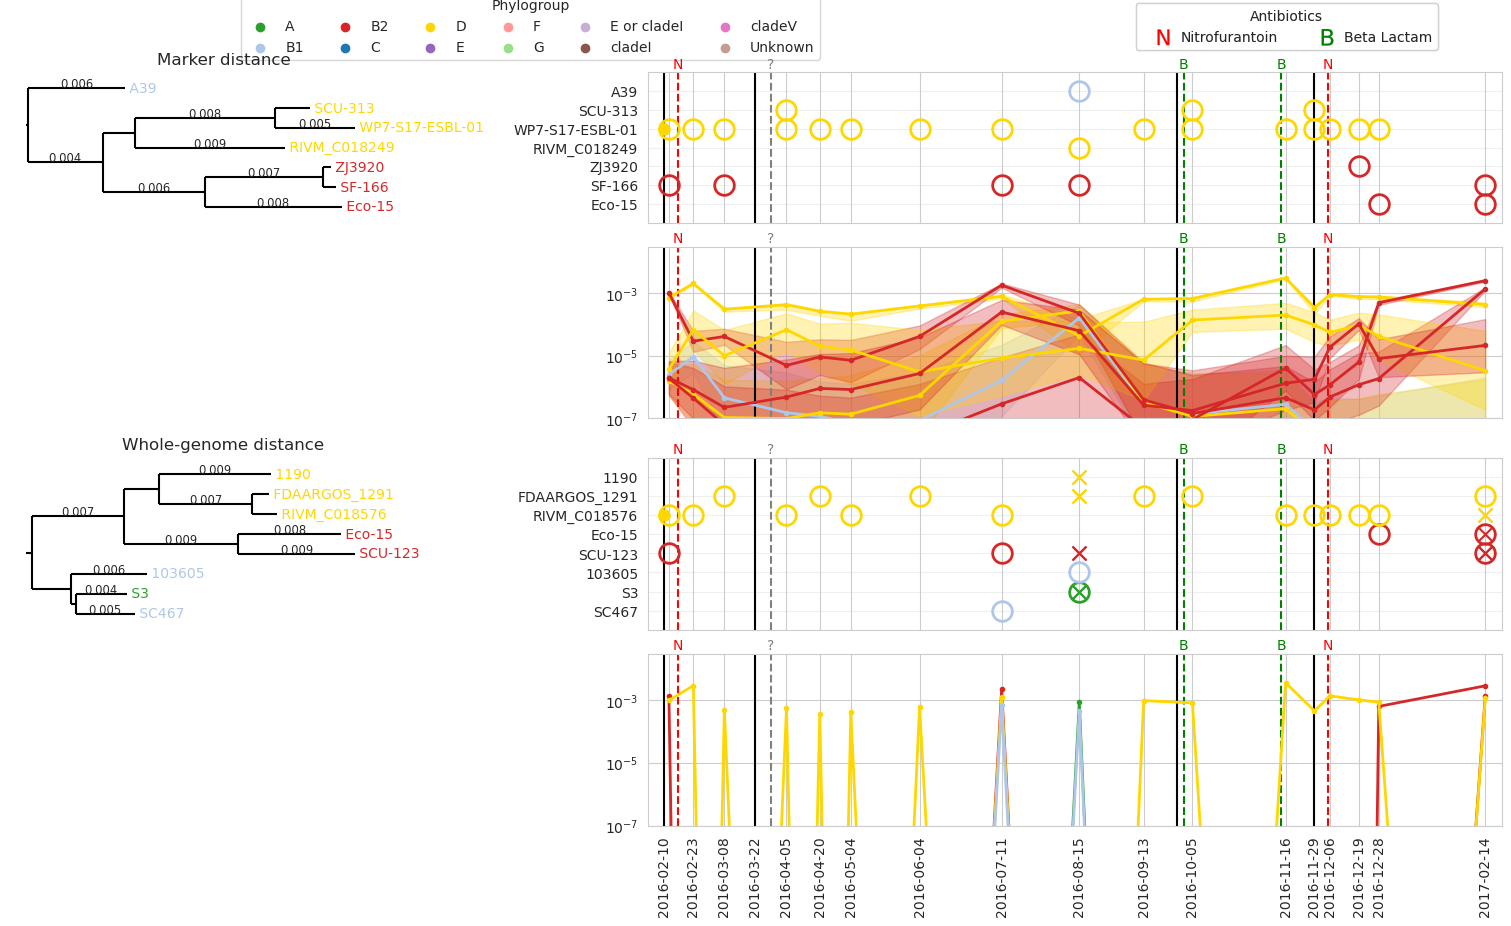

In [104]:
umb_id = 'UMB18'
load_result(umb_id)
plot_umb(
    umb_id, base_dir, seed=31415, result_cache=res_cache, width=15.0,
    include_straingst=True
)

plot_dir = Path() / 'plots'
plot_dir.mkdir(exist_ok=True)
plt.savefig(plot_dir / f'{umb_id}_both_methods.svg')

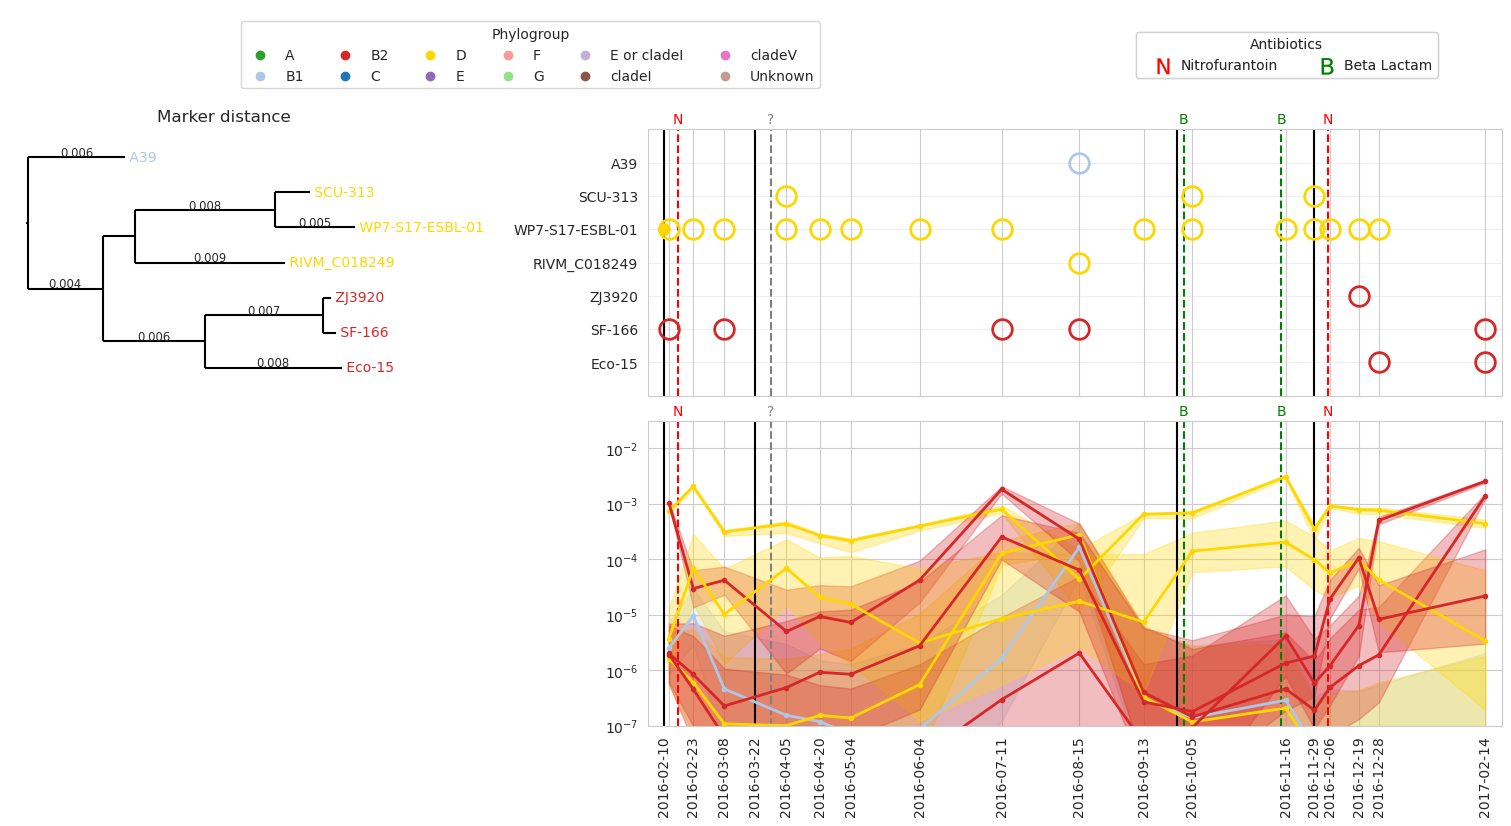

In [102]:
umb_id = 'UMB18'
load_result(umb_id)
plot_umb(
    umb_id, base_dir, seed=31415, result_cache=res_cache, width=15.0,
    include_straingst=False
)

plot_dir = Path() / 'plots'
plot_dir.mkdir(exist_ok=True)
plt.savefig(plot_dir / f'{umb_id}.svg')

In [13]:
x = []
for s in db.all_strains():
    if not s.metadata.species == 'coli':
        continue
    marker_len = sum(len(m) for m in s.markers)
    ratio = marker_len / s.metadata.total_len
    x.append(ratio)
np.mean(x)

0.02435537173614547

# Whole-dataset plot